<a href="https://colab.research.google.com/github/sayanbanerjee32/paddy_comp_with_jhoward/blob/main/multi_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install fastkaggle if not available
!pip install -Uq fastai
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

!pip install -Uq 'timm>=0.6.2.dev'
!pip install -Uq pynvml
from fastkaggle import *

     |████████████████████████████████| 512 kB 6.5 MB/s 
     |████████████████████████████████| 46 kB 2.3 MB/s 


In [3]:
import fastai
fastai.__version__

'2.7.6'

In [4]:
# import colab libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

In [6]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
from fastai.vision.all import *
set_seed(42)

from fastcore.parallel import *
trn_path = path/'train_images'

100%|██████████| 1.02G/1.02G [00:07<00:00, 140MB/s]


In [8]:
tst_files = get_image_files(path/'test_images').sorted()

In [9]:
df = pd.read_csv(path/'train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [10]:
# function get varity from image path
def get_variety(p): return df.loc[p.name, 'variety']

In [11]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

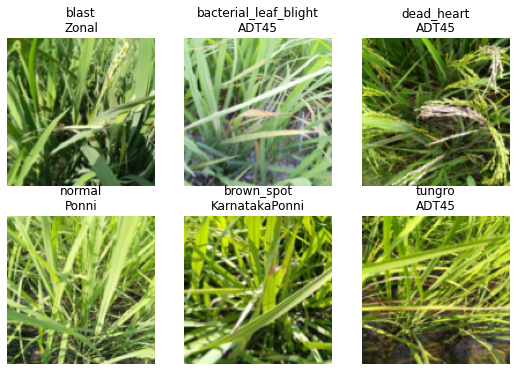

In [12]:
dls.show_batch(max_n=6)

In [ ]:
# revised loss and metric function for diese target
def disease_err(inp,disease,variety): return error_rate(inp,disease)
def disease_loss(inp,disease,variety): return F.cross_entropy(inp,disease)

### replicate single target model

In [ ]:
arch = 'convnext_small_in22k'
learn = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
lr = 0.01

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


In [ ]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.330953,0.785519,0.261893,01:53


epoch,train_loss,valid_loss,disease_err,time
0,0.670292,0.469898,0.145603,01:53
1,0.510557,0.377688,0.118212,01:38
2,0.344358,0.253277,0.083614,01:40
3,0.205771,0.178630,0.053340,01:50
4,0.141639,0.151530,0.047573,01:52


### Now multi-target model

In [ ]:
learn = vision_learner(dls, arch, n_out=20).to_fp16()

In [13]:
# loss functions for multi target
def disease_loss(inp,disease,variety): return F.cross_entropy(inp[:,:10],disease)
def variety_loss(inp,disease,variety): return F.cross_entropy(inp[:,10:],variety)
def combine_loss(inp,disease,variety): return disease_loss(inp,disease,variety)+variety_loss(inp,disease,variety)

In [14]:
# error rate for multi target
def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)

err_metrics = (disease_err,variety_err)

In [15]:
all_metrics = err_metrics+(disease_loss,variety_loss)

In [ ]:
learn = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()

In [ ]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.412918,1.246590,0.280634,0.131187,0.844645,0.401945,01:37


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.097929,0.661562,0.143200,0.059106,0.458844,0.202718,01:49


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.097929,0.661562,0.143200,0.059106,0.458844,0.202718,01:49
1,0.816843,0.516041,0.121576,0.053340,0.367372,0.148669,01:39
2,0.529266,0.349349,0.082172,0.025949,0.264203,0.085147,01:37
3,0.321793,0.245153,0.055742,0.020663,0.180125,0.065027,01:36
4,0.213534,0.207901,0.051418,0.015377,0.156455,0.051446,01:35


In [ ]:
# check tta shape
tst_tta = learn.tta(dl=dls.test_dl(tst_files))

In [ ]:
len(tst_tta), tst_tta[0].shape, tst_tta[1], tst_tta[0][:,:10].shape

(2, torch.Size([3469, 20]), None, torch.Size([3469, 10]))

## Larger model ensemble with multi target

In [62]:
!nvidia-smi

Thu Jul 14 11:38:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    34W / 250W |   1015MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12):
    # dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item,
    #     batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    # replacing dls
    dls = DataBlock(
        blocks=(ImageBlock,CategoryBlock,CategoryBlock),
        n_inp=1,
        get_items=get_image_files,
        get_y = [parent_label,get_variety],
        splitter=RandomSplitter(0.2),
        item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75)
    ).dataloaders(trn_path, bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(dl=dls.test_dl(tst_files))[0][:,:10] #
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [17]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
train('convnext_small_in22k', 128, epochs=1, accum=2, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,nan,nan,0.951466,0.325324,nan,nan,01:53


GPU:0
process      30311 uses     2967.000 MB GPU memory


In [ ]:
train('convnext_small_in22k', 128, epochs=1, accum=4, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.264304,2.662458,0.580010,0.283037,1.700170,0.962288,02:29


GPU:0
process       7590 uses    11745.000 MB GPU memory


In [ ]:
train('convnext_large_in22k', 224, epochs=1, accum=4, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.754590,2.074079,0.479577,0.241711,1.373721,0.700358,06:15


GPU:0
process       7590 uses    11863.000 MB GPU memory


In [ ]:
train('convnext_large_in22k', (320,240), epochs=1, accum=4, finetune=False)
report_gpu()

In [ ]:
train('vit_large_patch16_224', 224, epochs=1, accum=4, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,nan,nan,0.954349,0.324844,nan,nan,09:16


GPU:0
process      30311 uses    11043.000 MB GPU memory


In [ ]:
train('swinv2_large_window12_192_22k', 192, epochs=1, accum=4, finetune=False)
report_gpu()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.968819,3.412042,0.823162,0.325805,2.166118,1.245924,06:26


GPU:0
process      30311 uses     9051.000 MB GPU memory


In [ ]:
train('swin_large_patch4_window7_224', 224, epochs=1, accum=4, finetune=False)
report_gpu()

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,4.001919,3.405355,0.817396,0.327727,2.159537,1.245818,06:40


GPU:0
process      30311 uses     8305.000 MB GPU memory


In [63]:
res = 640,480
trn_path = path/'train_images'
models = {
    'convnext_large_in22k': {
        (Resize(res), (320,224)),
    }, 'vit_large_patch16_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }, 'swinv2_large_window12_192_22k': {
        (Resize(480, method='squish'), 192),
        (Resize(res), 192),
    }, 'swin_large_patch4_window7_224': {
        (Resize(res), 224),
    }
}

In [64]:
tta_res = []
gc.collect()
torch.cuda.empty_cache()
for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        tta_res.append(train(arch, size, item=item, accum=4)) #, epochs=1))
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_large_in22k
(320, 224)
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.895597,1.302874,0.188852,0.175877,0.666747,0.636128,09:06


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,0.645655,0.415397,0.088419,0.041807,0.291491,0.123906,15:09
1,0.582547,0.388749,0.078328,0.037963,0.257575,0.131174,15:09
2,0.548650,0.404965,0.084094,0.027871,0.312514,0.092450,15:08
3,0.431692,0.349263,0.074964,0.025949,0.262444,0.086819,15:09
4,0.417035,0.259832,0.060067,0.015377,0.216206,0.043626,15:09
5,0.279398,0.191390,0.037482,0.011533,0.159197,0.032192,15:08
6,0.179963,0.160698,0.034599,0.009130,0.134170,0.026527,15:08
7,0.127991,0.126052,0.026430,0.004805,0.104992,0.021060,15:08
8,0.070644,0.143345,0.024507,0.005766,0.119594,0.023751,15:08
9,0.060628,0.117891,0.023546,0.005766,0.099035,0.018856,15:08


--- vit_large_patch16_224
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.120037,1.085078,0.209034,0.138395,0.657872,0.427206,06:45


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,0.715762,0.353342,0.079289,0.031235,0.255008,0.098334,09:33
1,0.713968,0.609494,0.122057,0.057665,0.407066,0.202428,09:34
2,0.858033,0.747765,0.134551,0.100432,0.430125,0.317639,09:34
3,0.551590,0.330914,0.076886,0.025949,0.249803,0.081111,09:35
4,0.482427,0.428712,0.084094,0.033638,0.286987,0.141726,09:34
5,0.330578,0.243140,0.053820,0.019222,0.182353,0.060787,09:35
6,0.215077,0.188769,0.035560,0.011533,0.147650,0.041119,09:36
7,0.133562,0.176948,0.031235,0.012975,0.129123,0.047824,09:35
8,0.079932,0.143502,0.024988,0.007208,0.110865,0.032637,09:35
9,0.060538,0.123535,0.020183,0.009130,0.087129,0.036406,09:34


--- vit_large_patch16_224
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.926139,1.058640,0.214320,0.099471,0.769970,0.288670,06:45


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,0.813193,0.406169,0.092263,0.043729,0.286801,0.119368,09:33
1,0.767740,0.477963,0.102835,0.051898,0.327882,0.150080,09:33
2,0.586829,0.339287,0.084575,0.024507,0.273090,0.066198,09:35
3,0.609319,0.343162,0.077367,0.020183,0.279452,0.063710,09:34
4,0.438049,0.461680,0.102355,0.041807,0.334353,0.127327,09:33
5,0.384294,0.262648,0.052379,0.016338,0.210371,0.052277,09:33
6,0.203664,0.179703,0.038443,0.012975,0.144689,0.035014,09:33
7,0.158843,0.151488,0.036521,0.005766,0.132275,0.019213,09:33
8,0.108361,0.109139,0.021624,0.003364,0.099175,0.009964,09:32
9,0.047430,0.105243,0.021624,0.001922,0.097106,0.008137,09:33


--- swinv2_large_window12_192_22k
192
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.025868,1.269457,0.222009,0.136953,0.760978,0.508480,04:52


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,0.760943,0.362359,0.081211,0.032677,0.262914,0.099445,06:30
1,0.670468,0.454439,0.105718,0.043729,0.328930,0.125509,06:29
2,0.632966,0.538622,0.100913,0.064392,0.331686,0.206937,06:29
3,0.532199,0.278551,0.073042,0.017780,0.220841,0.057711,06:30
4,0.384273,0.303586,0.057184,0.032196,0.215932,0.087654,06:29
5,0.284225,0.232411,0.040365,0.017299,0.163768,0.068643,06:30
6,0.195653,0.171314,0.030274,0.012494,0.116314,0.055001,06:30
7,0.166417,0.136409,0.026910,0.007208,0.099402,0.037007,06:30
8,0.080552,0.119634,0.022585,0.003844,0.096456,0.023178,06:30
9,0.078386,0.091577,0.018260,0.003844,0.069525,0.022052,06:30


--- swinv2_large_window12_192_22k
192
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.973836,1.365530,0.238827,0.160980,0.739664,0.625867,04:51


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,0.742540,0.299754,0.071120,0.021144,0.235643,0.064111,06:29
1,0.603225,0.370679,0.075444,0.032196,0.260769,0.109911,06:30
2,0.651260,0.482208,0.093224,0.041326,0.359978,0.122230,06:30
3,0.528027,0.361896,0.067756,0.029313,0.253857,0.108039,06:30
4,0.482942,0.279128,0.057184,0.017299,0.231080,0.048048,06:30
5,0.331481,0.240950,0.044210,0.017780,0.181676,0.059274,06:32
6,0.170544,0.179440,0.030754,0.010572,0.145405,0.034035,06:31
7,0.139813,0.162175,0.029313,0.008169,0.133629,0.028546,06:30
8,0.111740,0.130173,0.020663,0.006728,0.114675,0.015498,06:30
9,0.073809,0.123050,0.018260,0.004325,0.109099,0.013951,06:31


--- swin_large_patch4_window7_224
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.803857,1.164422,0.206631,0.116771,0.768526,0.395897,04:57


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,0.724585,0.357163,0.079769,0.033157,0.261516,0.095648,06:42
1,0.722356,0.345811,0.080250,0.028832,0.255564,0.090247,06:40
2,0.616674,0.403732,0.077367,0.042287,0.281536,0.122196,06:41
3,0.496307,0.311531,0.061509,0.026430,0.232653,0.078878,06:41
4,0.366349,0.224846,0.047573,0.014416,0.178470,0.046376,06:41
5,0.284771,0.201579,0.043248,0.009130,0.170175,0.031404,06:41
6,0.207726,0.176805,0.043248,0.008169,0.143262,0.033543,06:40
7,0.157726,0.136812,0.031235,0.009130,0.104388,0.032423,06:41
8,0.140184,0.115560,0.020663,0.008650,0.085965,0.029595,06:42
9,0.065270,0.107311,0.023066,0.007208,0.084321,0.022990,06:42


In [65]:
len(tta_res), tta_res[0].shape

(6, torch.Size([3469, 10]))

### Ensembling

In [66]:
tta_prs = [t.clone().detach() for t in tta_res] # first(zip(*tta_res))
tta_prs += tta_prs[0:2]
tta_prs.append(tta_prs[3])
len(tta_prs), [type(t) for t in tta_prs]

(9,
 [fastai.torch_core.TensorBase,
  torch.Tensor,
  torch.Tensor,
  torch.Tensor,
  torch.Tensor,
  torch.Tensor,
  fastai.torch_core.TensorBase,
  torch.Tensor,
  torch.Tensor])

In [67]:
avg_pr = torch.stack(tta_prs).mean(0)
avg_pr.shape

torch.Size([3469, 10])

### Submission

In [68]:
ss = pd.read_csv(path/'sample_submission.csv')
ss.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


In [69]:
# dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(480, method='squish'),
#     batch_tfms=aug_transforms(size=224, min_scale=0.75))
# tst_dl = dls.test_dl(tst_files)
dls.vocab

(#2) [['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro'],['ADT45', 'AndraPonni', 'AtchayaPonni', 'IR20', 'KarnatakaPonni', 'Onthanel', 'Ponni', 'RR', 'Surya', 'Zonal']]

In [70]:
idxs = avg_pr.argmax(dim=1)
vocab = np.array(dls.vocab[0])
ss['label'] = vocab[idxs]

In [71]:
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [72]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'multi-target ensemble large tta', comp)

100%|██████████| 70.5k/70.5k [00:00<00:00, 269kB/s]


In [ ]:
if not iskaggle:
    push_notebook('saan', 'paddy-initial-model',
                  title='Paddy initial model',
                  file='/content/drive/MyDrive/Colab Notebooks/paddy_comp_initial_model.ipynb',
                  competition=comp, private=True, gpu=True)

Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/saansd2003/paddy-initial-model
